In [10]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
# set up arrays
dx = 1000
x = np.arange(0, 100000, dx)
x_node = x + (dx/2)

Hstar = 0.5
etab = np.zeros(len(x)) # bedrock elevation, m
etab[:] = np.linspace(10, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x))
eta = etab + H

In [12]:
# set up parameters
# K_ig = np.zeros(len(x))
# K_ig[:24] = 1e-7
# K_sed = np.zeros(len(x))
# K_sed[24:] = 1e-6
K = np.zeros(len(x))
K[:] = 1e-6

# beta_ig = np.zeros(len(x))
# beta_ig[:24] = 4e-7
# beta_sed = np.zeros(len(x))
# beta_sed[24:] = 4e-6
beta = np.zeros(len(x))
beta[:] = 1/2000
# beta[:] = 1e-6

# psi = np.zeros(len(x))
# psi[:14] = 4e-7
# psi[14:] = 4e-6
psi = 1/2000
# psi = 1e-6
# psi = 1e-5
gamma = 0.3

r = 10. # runoff rate
D = 0.015 # grain size
phi = 0.1 # porosity
baselevel_rate = 0.0001 # baselevel fall rate

In [13]:
kqs = 0.041
I = 0.03
kxb = 25
Pxb = 1./5.
kb = 8.3e-8

B_valley = kxb * (x_node**Pxb)
B_basin = (2./3.) * x_node

area = (1./3.) * x**2
# Q = r * x * B
Q = r * area

In [14]:
def model(x, dx, x_node,
          K, beta,
          D, phi, Hstar, psi, gamma,
          kb, kqs, I, r, B_valley, B_basin, Q,
          etab, H, eta,
          baselevel_rate,
          num_steps = 1):
    
    q = Q/B_valley
    # dt = 0.2 * dx * dx / (kqs * q[-1]) # try changing to 10, 5, or 1 if this is unstable
    dt = 5
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x))
    
    H[-1] = 0
    E[-1] = baselevel_rate
    q[0] = 0
    Qs[0] = 0
    ql[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= baselevel_rate * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc Rh
#         width = (kb * Q[1:] * (S ** (7/6))) / (D**(3/2))
#         depth = (0.09801 * D) / S
#         Rh_efficiency = 1 - np.exp(-width/(2*depth))
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1]) # * Rh_efficiency
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K[1:] * Q[1:] * S * alpha[:-1]
        Eb_a[:-1] = beta[1:] * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc grain attrition
        atr = Qs * psi
        
        # calc equilibrium lateral supply
        ql[1:] = ((baselevel_rate * gamma) / psi) * (1 - np.exp(-psi/(3 * x[1:])))
        # ql[24:] = 0
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - Eb_p[:-1] - ql[1:])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, atr, ql, Eh, E, etab, H, eta)

In [15]:
#now write a test
num_steps = 5000000
test_run = [x, dx, x_node, 
            K, beta, 
            D, phi, Hstar, psi, gamma,
            kb, kqs, I, r, B_valley, B_basin, Q,
            etab, H, eta,
            baselevel_rate,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, atr, ql, Eh, E, etab, H, eta) = model(*test_run)

25000000.0


In [16]:
Eb

array([1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 0.e+00])

In [17]:
S

array([5.22457167e-03, 2.30878515e-03, 1.41883959e-03, 9.92095259e-04,
       7.43920160e-04, 5.83425078e-04, 4.72371521e-04, 3.91802642e-04,
       3.31242580e-04, 2.84439259e-04, 2.47441339e-04, 2.17638211e-04,
       1.93242718e-04, 1.72995177e-04, 1.55985649e-04, 1.41542870e-04,
       1.29162507e-04, 1.18459488e-04, 1.09135545e-04, 1.00956645e-04,
       9.37369943e-05, 8.73275206e-05, 8.16074418e-05, 7.64780180e-05,
       7.18578594e-05, 6.76793641e-05, 6.38859823e-05, 6.04300978e-05,
       5.72713694e-05, 5.43754231e-05, 5.17128122e-05, 4.92581838e-05,
       4.69896068e-05, 4.48880252e-05, 4.29368124e-05, 4.11214039e-05,
       3.94289940e-05, 3.78482836e-05, 3.63692701e-05, 3.49830697e-05,
       3.36817694e-05, 3.24583000e-05, 3.13063293e-05, 3.02201706e-05,
       2.91947039e-05, 2.82253087e-05, 2.73078058e-05, 2.64384071e-05,
       2.56136715e-05, 2.48304674e-05, 2.40859390e-05, 2.33774773e-05,
       2.27026950e-05, 2.20594033e-05, 2.14455925e-05, 2.08594145e-05,
      

In [18]:
# now do analytical solution testing

# terms
T1 = baselevel_rate * dx
T2 = psi * kqs * I
T3 = 1 - np.exp(-psi * x[1:])
T4 = K[1:] * T3
T5 = K[1:] * Q[1:]

# groups
G1 = T1
G2 = T2 / (T4 + T2)
G3 = T5 * G2 * T3 + T5

In [19]:
S_an = (G1 / (G2 * G3))**(6./7.)

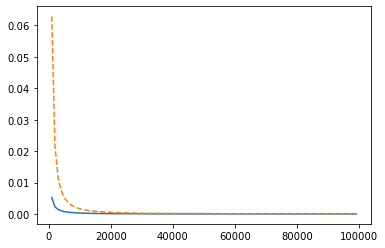

In [24]:
plt.plot(x[1:], S)
plt.plot(x[1:], S_an, linestyle = '--')